## Anomaly detection using time series classification approach

There are numerous techniques to detect anomalies in time series. Some of them are covered in tutirials for FedotIndustrial framework as far as it is designed solve this sort of task.

In this example we'd like to show you how to solve anomaly detection task using classification approach.

We will use randomly generated time series of univariate and multivariate types with anomaly labels.

This approach rely on construction of classification dataset based of time series and anomaly labels we have. The algorithm is designed so it will crop a time series into samples which are labeled as `anomaly` or `non_anomaly`, and then split this dataset into train and test parts which are ready to be fed into `FedotIndustrial` framework to solve time series classification task.

First, we need to import necessary for this particular example libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from fedot_ind.api.main import FedotIndustrial
from fedot_ind.core.operation.transformation.splitter import TSSplitter

For clarity of experiment we will use randomly generated time series and anomalies. Here is the function `generate_time_series` that returns generated time series and dictionary of randomly generated anomalies:

In [2]:
def generate_time_series(to_plot: bool = True,
                         ts_length: int = 500, 
                         num_anomaly_classes: int = 4, 
                         num_of_anomalies: int = 20,
                         min_anomaly_length: int = 5,
                         max_anomaly_length: int = 15):
    import matplotlib.patches as mpatches

    np.random.seed(42)

    initial_ts = np.random.normal(0, 1, ts_length)
    time_series = initial_ts.copy()
    anomaly_classes = [f'anomaly{i+1}' for i in range(num_anomaly_classes)]

    anomaly_intervals = {}
    
    for i in range(num_of_anomalies):
        anomaly_class = np.random.choice(anomaly_classes)

        start_idx = np.random.randint(max_anomaly_length, 
                                      ts_length - max_anomaly_length)

        end_idx = start_idx + np.random.randint(min_anomaly_length, 
                                                max_anomaly_length + 1)

        anomaly = np.random.normal(5, 1, end_idx - start_idx)

        time_series[start_idx:end_idx] += anomaly

        if anomaly_class in anomaly_intervals:
            anomaly_intervals[anomaly_class] += f', {start_idx}:{end_idx}'
        else:
            anomaly_intervals[anomaly_class] = f'{start_idx}:{end_idx}'

    if to_plot:
        fig, ax = plt.subplots(figsize=(15,7))
        ax.plot(time_series)
        ax.set_title('Time Series with Anomalies')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        
        cmap = generate_colors(len(anomaly_intervals.keys()))
        color_dict = {cls: color for cls, color in zip(anomaly_intervals.keys(), cmap)}
            
        legend_patches = [mpatches.Patch(color=color_dict[cls], 
                                                     label=cls) for cls in anomaly_intervals.keys()]
        
        for anomaly_class, intervals in anomaly_intervals.items():
            for interval in intervals.split(', '):
                start_idx, end_idx = map(int, interval.split(':'))
                ax.axvspan(start_idx, end_idx, alpha=0.3, color=color_dict[anomaly_class])


        plt.legend(handles=set(legend_patches))
        plt.show()

    return initial_ts, time_series, anomaly_intervals

def generate_colors(num_colors):
    # colormap = plt.cm.get_cmap('tab10')
    colormap = matplotlib.colormaps['tab10']
    colors = [colormap(i) for i in range(num_colors)]
    return colors

So, let's generate some time series of `length=1000` with `50` anomalies of `4` classes and take a look at the plot:

/var/folders/z4/vgrcwwd90xd8753w8y0vv1jc0000gn/T/ipykernel_12047/2856130695.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


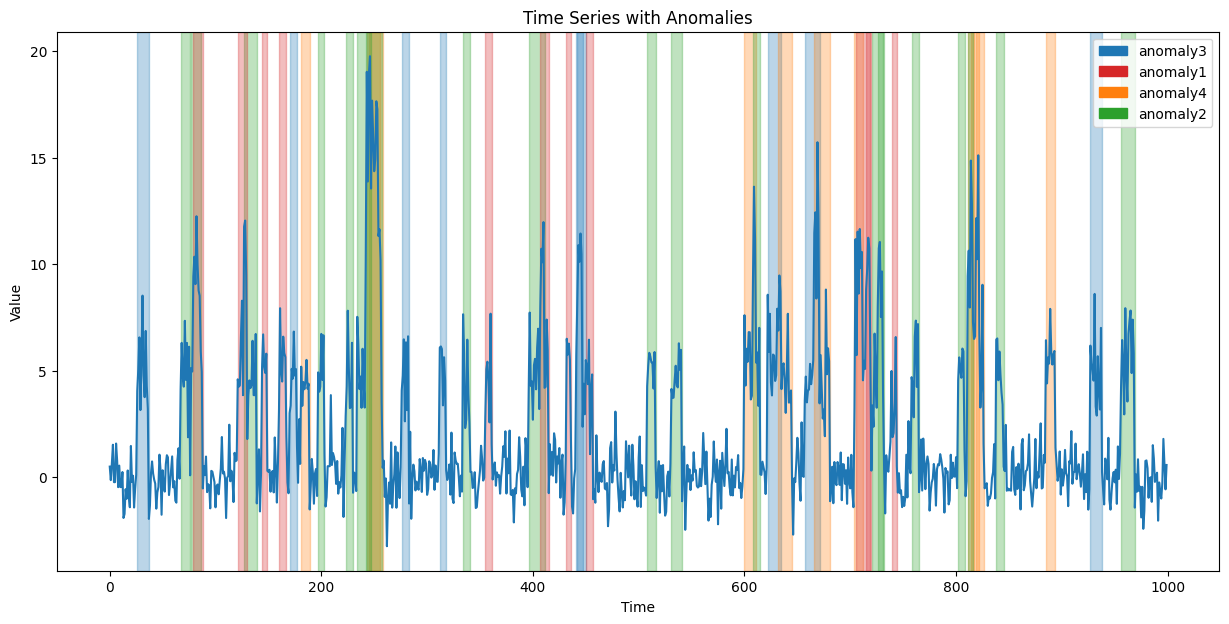

In [3]:
time_series, anomaly_intervals = generate_time_series(to_plot=True, 
                                                      ts_length=1000, 
                                                      num_anomaly_classes=4, 
                                                      num_of_anomalies=50)

At the plot we can that some anomalies are overlap but not entirely. It could be consideres as a case when we are trying to distinguish overlapping animalies of different type.

In [4]:
anomaly_intervals

{'anomaly3': '442:447, 26:37, 657:671, 622:635, 312:318, 441:450, 170:177, 276:283, 927:938',
 'anomaly4': '704:712, 245:258, 600:611, 819:826, 181:189, 632:645, 814:822, 666:681, 811:817, 243:255, 885:894',
 'anomaly2': '721:731, 811:816, 531:541, 67:76, 508:516, 956:969, 234:247, 334:341, 726:732, 223:230, 608:615, 802:808, 396:411, 77:86, 197:203, 758:765, 242:257, 127:139, 838:845',
 'anomaly1': '121:130, 705:719, 739:744, 431:436, 160:167, 355:361, 450:457, 79:88, 144:149, 715:720, 407:415'}

Now, as far as we have time series and anomaly labels, the `TSSplitter` class could be invited to our party. To do it all we need is to instantiate this class with three arguments:

- `time series` (univariate or multivariate in the form `List[time_series]`
- `anomaly_dict` - dictionary with labels of every anomaly class
- `strategy` - the way how dataset is going to formed.

Strategy could be of two types:

- `frequent` - it is when anomaly classes are preserved, but their intervals are transformed to the most frequent length
- `unique` – every combination of anomaly class and particular length are considered as unique anomaly. In this case the output of `split` method will be tuple of three objects: a list of unique anomaly names, list of train subsets and list of test subsets

In [5]:
splitter = TSSplitter(time_series=time_series, 
                      anomaly_dict=anomaly_intervals,
                      strategy='frequent')

Then we need to call `split` method with two arguments which names are speak for themselfs:

- `plot` tells whether to produce visualisation of initial time series, anomalies and selected non-anomaly intervals
- `binarize` argument could be used in case when there is huge class imbalance and it is more appropriate to combine all anomaly classes into one rather that trying to distinguish them

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/fedot_ind/core/operation/transformation/splitter.py:242: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes[1].axvspan(interval_[0], interval_[1], alpha=0.3, color='blue', edgecolor="black")
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/fedot_ind/core/operation/transformation/splitter.py:245: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes[0].axvspan(interval[0], interval[1], alpha=0.3, color='red', edgecolor="black")
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/fedot_ind/core/operation/transformation/splitter.py:250: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes[2].axvspan(interval[0], interval[1], alpha=0.3, color='green', edgecolor="black")


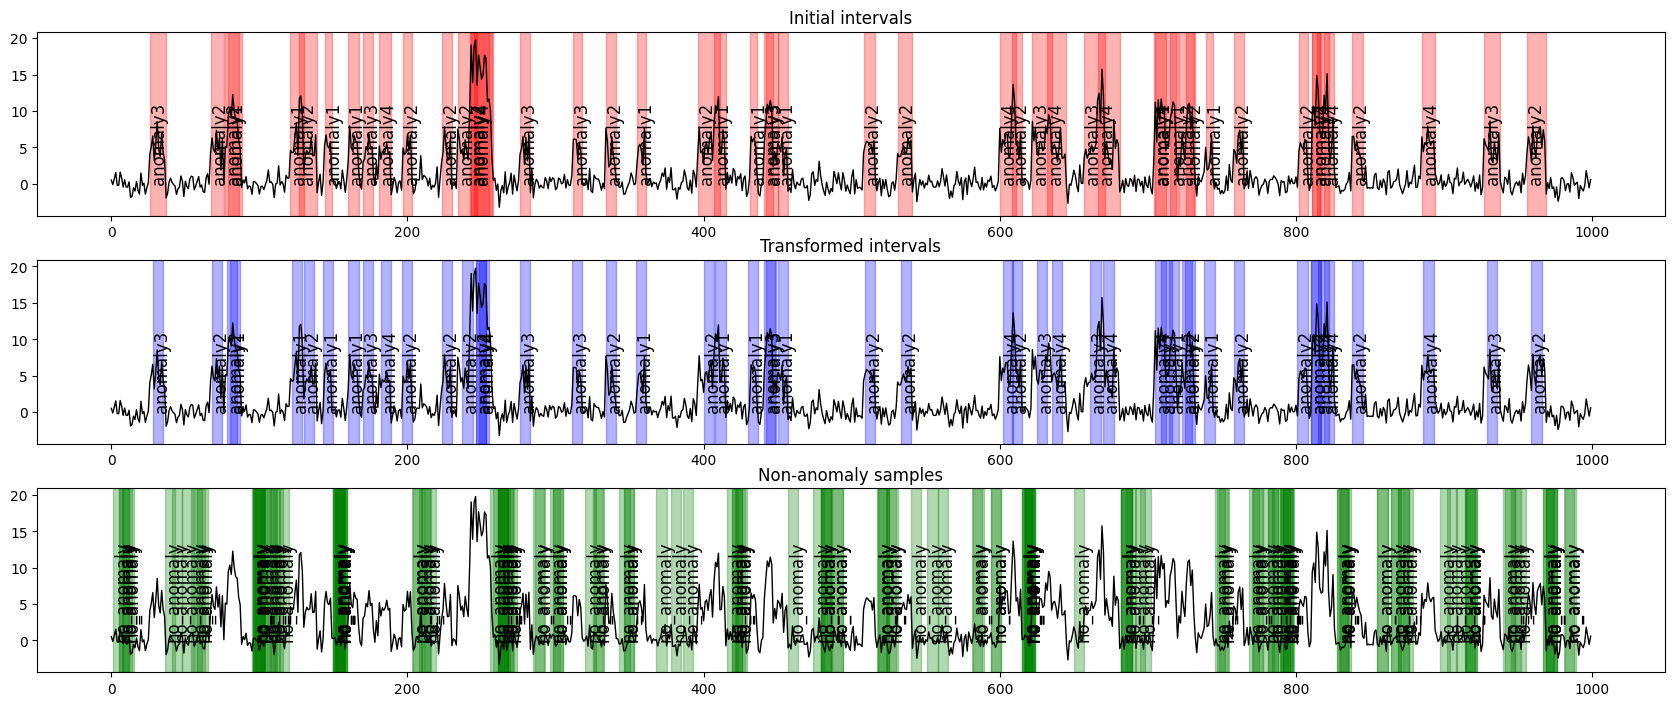

In [ ]:
train_data, test_data = splitter.split(plot=True, 
                                       binarize=False)

Now, when our data is ready we can commence to use FedotIndustrial framework in terms of time series classification task.

For this purpose, it is necessary to import the base class FedotIndustrial and determine the parameters of the experiment:

In [14]:
industrial = FedotIndustrial(task='ts_classification',
                             dataset='custom_dataset',
                             strategy='fedot_preset',
                             use_cache=False,
                             timeout=1,
                             n_jobs=2,
                             logging_level=20,
                             output_folder='.')

2023-06-02 11:57:57,229 - Initialising experiment setup
2023-06-02 11:57:57,231 - Experiment setup:
        dataset - custom_dataset,
        strategy - fedot_preset,
        use_cache - False,
        n_jobs - 2,
        timeout - 1
2023-06-02 11:57:57,233 - Initialising solver
2023-06-02 11:57:57,234 - TimeSeriesClassifierPreset initialised


In [13]:
model = industrial.fit(train_features=train_data[0],
                       train_target=train_data[1])

AttributeError: 'list' object has no attribute 'min'

{'depth': 2, 'length': 2, 'nodes': [rf, scaling]}


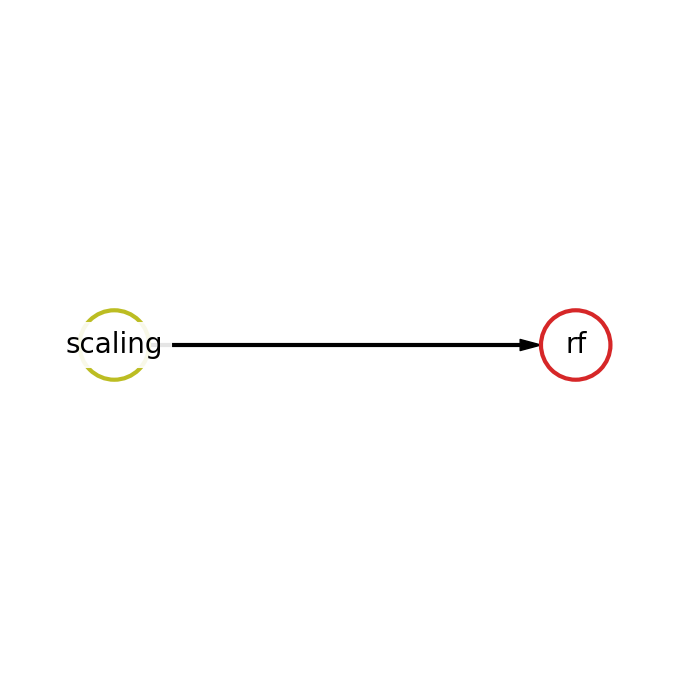

In [65]:
print(model.current_pipeline)

model.current_pipeline.show(node_size_scale=0.5)

In [66]:
labels = industrial.predict(test_features=test_data[0],
                            test_target=test_data[1])

probs = industrial.predict_proba(test_features=test_data[0],
                                 test_target=test_data[1])

print(labels)

2023-06-01 16:44:56,008 - Predicting with statistical generator
2023-06-01 16:44:56,655 - Predicting with statistical generator
[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]]


In [67]:
print(probs)

[[0.03]
 [1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [0.  ]
 [0.05]
 [1.  ]
 [0.01]
 [1.  ]
 [0.  ]
 [0.36]
 [1.  ]
 [1.  ]
 [1.  ]
 [0.  ]
 [1.  ]
 [0.  ]
 [0.  ]
 [0.97]
 [1.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.02]
 [1.  ]
 [0.  ]
 [0.97]
 [0.97]
 [1.  ]
 [1.  ]
 [0.36]
 [1.  ]
 [1.  ]
 [0.04]
 [0.1 ]
 [1.  ]
 [0.79]
 [0.  ]
 [0.5 ]
 [0.98]
 [1.  ]
 [1.  ]
 [0.01]
 [0.03]
 [0.97]
 [0.05]
 [1.  ]
 [0.14]
 [1.  ]
 [1.  ]
 [0.  ]
 [0.  ]
 [0.96]
 [1.  ]
 [1.  ]
 [0.04]
 [0.75]
 [0.  ]
 [0.  ]
 [0.  ]
 [1.  ]
 [1.  ]
 [0.01]
 [1.  ]
 [0.03]
 [0.95]
 [0.96]
 [0.  ]
 [0.  ]
 [0.98]
 [0.  ]
 [0.  ]
 [1.  ]
 [0.05]
 [0.01]
 [1.  ]
 [0.  ]
 [0.  ]]


In [76]:
from sklearn.metrics import classification_report

print(classification_report(test_data[1], labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

